# Explore here



Step 0: Import libraries and data

In [22]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
#Load data
url = "https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"

df_raw = pd.read_csv(url)

Step 1: Basic exploration

In [5]:
df_raw.info()
#7 variables, 1338 obs, no nulls
#Data type 'object': probably categorical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df_raw.sample(10)
#Sex, smoker and region are categorical
#Dataset heterogéneo (distintos datatypes)

,age,sex,bmi,children,smoker,region,charges
553,52,female,31.730,2,no,northwest,11187.65670
674,44,female,43.890,2,yes,southeast,46200.98510
1248,18,female,39.820,0,no,southeast,1633.96180
379,62,male,31.460,1,no,southeast,27000.98473
856,48,female,33.110,0,yes,southeast,40974.16490
28,23,male,17.385,1,no,northwest,2775.19215
147,51,female,37.730,1,no,southeast,9877.60770
927,57,female,20.100,1,no,southwest,12032.32600
286,46,female,48.070,2,no,northeast,9432.92530
1205,35,male,17.860,1,no,northwest,5116.50040


Step 2: Variable transformation

In [5]:
df_raw.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

In [6]:
df_raw.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [7]:
df_raw.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [8]:
#Encoding (codificamos valor de variables categóricas)
#Rule: columnas de la clase x = categorías - 1 (Ej.: región tiene 4 categorías, necesito 3 columnas para evitar colinealidad)
#Could also be done with get dummies

df_raw['sex_aux'] = df_raw['sex'].apply(lambda x:1 if x == 'female' else 0)
df_raw['smoker_aux'] = df_raw['smoker'].apply(lambda x:1 if x == 'yes' else 0)
df_raw['region_sw'] = df_raw['region'].apply(lambda x:1 if x == 'southwest' else 0)
#southeast es la de referencia, por eso no creamos columna para southeast
df_raw['region_nw'] = df_raw['region'].apply(lambda x:1 if x == 'northwest' else 0)
df_raw['region_ne'] = df_raw['region'].apply(lambda x:1 if x == 'northeast' else 0)

df_raw = df_raw.drop(['sex', 'smoker', 'region'], axis = 1)
df_interim = df_raw.copy()

In [9]:
df_interim.sample(10)

,age,bmi,children,charges,sex_aux,smoker_aux,region_sw,region_nw,region_ne
1220,30,21.945,1,4718.20355,1,0,0,0,1
1101,53,28.600,3,11253.42100,0,0,1,0,0
571,18,37.290,1,2219.44510,1,0,0,0,0
803,18,42.240,0,38792.68560,1,1,0,0,0
193,56,26.600,1,12044.34200,1,0,0,1,0
1089,56,22.100,0,10577.08700,0,0,1,0,0
666,49,28.700,1,8703.45600,0,0,1,0,0
1085,39,18.300,5,19023.26000,1,1,1,0,0
961,29,25.900,0,3353.28400,1,0,1,0,0
220,34,33.700,1,5012.47100,1,0,1,0,0


Step 3: EDA

* Step 3.1: Select train and test data

In [9]:
X = df_interim[['age', 'bmi', 'children', 'sex_aux', 'smoker_aux', 'region_sw', 'region_nw', 'region_ne']] #IV
y = df_interim['charges'] #DV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 15)

* Step 3.2: Data descriptive stats

In [11]:
X_train.describe()

,age,bmi,children,sex_aux,smoker_aux,region_sw,region_nw,region_ne
count,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000
mean,39.419741,30.712687,1.093719,0.493519,0.207378,0.245264,0.242273,0.240279
std,14.107312,6.022157,1.210891,0.500207,0.405631,0.430458,0.428672,0.427466
min,18.000000,15.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,26.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,30.495000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,34.590000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,64.000000,53.130000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* Step 3.3: Univariate analysis

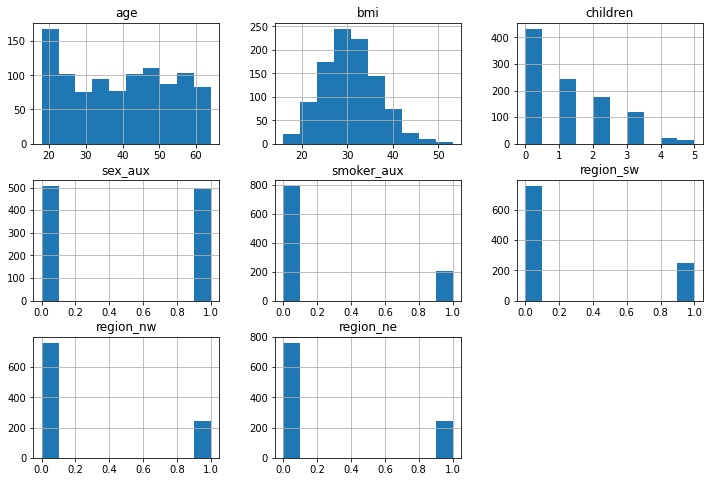

In [12]:
#Histogram
X_train.hist(figsize=(12,8))
plt.show()

#BMI parece normal
#Age parece estar balanceada aunque tiene un pico en 20
#Children la mayoría no tiene

* Step 3.4: Bivariate analysis (One var against the other)

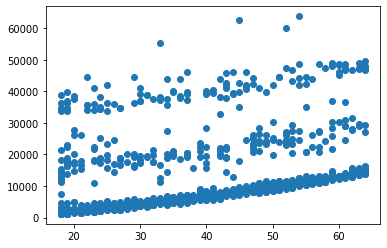

In [6]:
#Scatter plot
plt.scatter(x = X_train['age'], y = y_train)
plt.show()

#No se ve una relación lineal pero podríamos pensar que hay 3 clases 
#porque el costo del seguro puede variar según edad

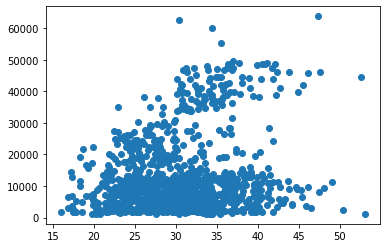

In [14]:
#Scatter plot
plt.scatter(x = X_train['bmi'], y = y_train)
plt.show()
#Podemos ver tres estratas

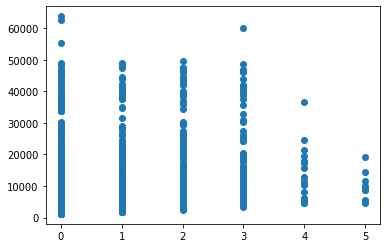

In [15]:
#Scatter plot
plt.scatter(x = X_train['children'], y = y_train)
plt.show()

* Step 3.5: Ver correlaciones

In [16]:
X_train.corr()
#No hay correlación (es casi 0, ninguna es mayor que 0.8) entre niños y edad, niños con bmi

,age,bmi,children,sex_aux,smoker_aux,region_sw,region_nw,region_ne
age,1.000000,0.112148,0.033683,0.024641,-0.007902,-0.031103,0.016999,-0.003667
bmi,0.112148,1.000000,-0.006800,-0.058002,0.011736,-0.024031,-0.108667,-0.152964
children,0.033683,-0.006800,1.000000,-0.015473,0.011188,0.013298,0.038888,-0.031980
sex_aux,0.024641,-0.058002,-0.015473,1.000000,-0.057313,0.007389,0.009657,-0.018381
smoker_aux,-0.007902,0.011736,0.011188,-0.057313,1.000000,-0.022948,-0.042431,-0.017141
region_sw,-0.031103,-0.024031,0.013298,0.007389,-0.022948,1.000000,-0.322341,-0.320591
region_nw,0.016999,-0.108667,0.038888,0.009657,-0.042431,-0.322341,1.000000,-0.318000
region_ne,-0.003667,-0.152964,-0.031980,-0.018381,-0.017141,-0.320591,-0.318000,1.000000


In [17]:
X_train.corr().style.background_gradient(cmap = 'Blues')
#Same but looks prettier

,age,bmi,children,sex_aux,smoker_aux,region_sw,region_nw,region_ne
age,1.000000,0.112148,0.033683,0.024641,-0.007902,-0.031103,0.016999,-0.003667
bmi,0.112148,1.000000,-0.006800,-0.058002,0.011736,-0.024031,-0.108667,-0.152964
children,0.033683,-0.006800,1.000000,-0.015473,0.011188,0.013298,0.038888,-0.031980
sex_aux,0.024641,-0.058002,-0.015473,1.000000,-0.057313,0.007389,0.009657,-0.018381
smoker_aux,-0.007902,0.011736,0.011188,-0.057313,1.000000,-0.022948,-0.042431,-0.017141
region_sw,-0.031103,-0.024031,0.013298,0.007389,-0.022948,1.000000,-0.322341,-0.320591
region_nw,0.016999,-0.108667,0.038888,0.009657,-0.042431,-0.322341,1.000000,-0.318000
region_ne,-0.003667,-0.152964,-0.031980,-0.018381,-0.017141,-0.320591,-0.318000,1.000000


* Step 4: Fit model

Reminder: 
<br> La variable dependiente es *charges*
<br> Las variables independientes son *age, bmi, children, sex, smoker* y *region*


4.1 Regresión lineal con constante

In [20]:
model = LinearRegression() #Initialize
model.fit(X_train, y_train) #Fit

print( "Intercept: ", model.intercept_ )
print("Variables: ", X_train.columns)
print( "Coeficientes: ", model.coef_ )

Intercept:  -13188.887965032352
Variables:  Index(['age', 'bmi', 'children', 'sex_aux', 'smoker_aux', 'region_sw',
       'region_nw', 'region_ne'],
      dtype='object')
Coeficientes:  [  259.28377294   334.33013348   560.38480047   216.92164981
 24043.57115706   169.84707402   948.64699482  1159.01410243]


In [23]:
X_interceptor = sm.add_constant(X_train)
model2 = sm.OLS(y_train, X_interceptor)
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     351.2
Date:                Thu, 07 Jul 2022   Prob (F-statistic):          1.85e-283
Time:                        12:48:06   Log-Likelihood:                -10183.
No. Observations:                1003   AIC:                         2.038e+04
Df Residuals:                     994   BIC:                         2.043e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.319e+04   1288.395    -10.237      0.000   -1.57e+04   -1.07e+04
age          259.2838     14.094     18.396      0.000     231.626     286.942
bmi          334.3301     33.696      9.922      0.000     268.206     400.454
children     560.3848    161.831      3.463      0.001     242.816     877.954
sex_aux      216.9216    397.204      0.546      0.585    -562.532     996.376
smoker_aux  2.404e+04    499.031     48.181      0.000    2.31e+04     2.5e+04
region_sw    169.8471    557.092      0.305      0.761    -923.364    1263.058
region_nw    948.6470    577.717      1.642      0.101    -185.037    2082.331
region_ne   1159.0141    572.395      2.025      0.043      35.773    2282.255
==============================================================================
Omnibus:                      231.741   Durbin-Watson:                   2.155
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              545.491
Skew:                           1.239   Prob(JB):                    3.53e-119
Kurtosis:                       5.629   Cond. No.                         357.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Esto es otra forma de hacer el modelo anterior:

In [10]:
sklm = LinearRegression()
sklm.fit(X_train, y_train) 
score = sklm.score(X_train, y_train)
print(f'El R square del dataset de aprendizaje es {score: .4f}')
#Note to self: Esto significa que 74% de la variable dependiente está explicada por la varianza de la independiente
#Note to self: Cuanto más cercano a 1 es el R square mejor ajusta el modelo, o sea la y estaría siendo 'perfectamente' explicada por las x

El R square del dataset de aprendizaje es  0.7387


In [11]:
predictions = sklm.predict(X_test)
print(f'El R square del dataset de prueba es {r2_score(y_test, predictions)}')
print(f'El RMSE es {mean_squared_error(y_test, predictions, squared = False)}')

El R square del dataset de prueba es 0.7866857073627449
El RMSE es 5542.845553222645


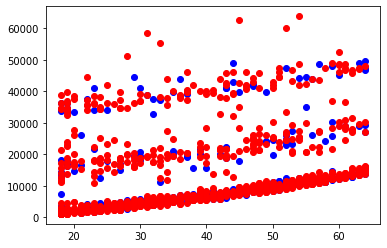

In [35]:
#Para ver el ajuste gráficamente
plt.scatter(x = X_test.iloc[:,0], y = y_test, color = 'Blue')
plt.scatter(x = X_train.iloc[:,0], y = y_train, color = 'Red')
plt.show()

4.2 Regresión lineal sin constante